# Agentic Framework in Llama Index

## Tool Use

The FunctionTool module can be used here to convert any function into a tool that the agent could call if it feels the necessity



In [23]:
import requests
from llama_index.core.tools import FunctionTool
from llama_index.core.agent import ReActAgent

from llama_index.llms.openai import OpenAI
import nest_asyncio
from llama_index.agent.introspective import IntrospectiveAgentWorker
from llama_index.agent.introspective import (
    ToolInteractiveReflectionAgentWorker,
)
import os

import dotenv


from llama_index.agent.openai import OpenAIAgentWorker
from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.llms import ChatMessage, MessageRole
from llama_index.core import ChatPromptTemplate

nest_asyncio.apply()

dotenv.load_dotenv()

True

In [25]:
# Declare API_KEY and OPENAI_API_KEY.
# Load API Keys
API_KEY = os.getenv('OPENWEATHER_API_KEY')
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

### 1. To access external API data 

In [26]:
def get_weather(city_name, units='imperial'):
    """
    Function that taken in a city name and units and returns the temperature and description of weather

    Args:
    city_name: The name of the city (ex: Los Angeles)
    units: The measurement units for tempreature (Options: imperial - fahreinheit, metric - celsius), Default: fahrenheit (imperial)

    Return:
    city: Name of the City
    temperature: the temperature in the provided measurement units
    description: the short description of the weather
    """
    base_url = "http://api.openweathermap.org/data/2.5/weather?"
    complete_url = base_url + "appid=" + API_KEY + "&q=" + city_name + "&units=" + units
    
    response = requests.get(complete_url)
    
    if response.status_code == 200:
        weather_data = response.json()
        return {
            'city': city_name,
            'temperature': weather_data['main']['temp'],
            'description': weather_data['weather'][0]['description']
        }
    else:
        return {'error': 'Failed to retrieve weather data', 'status_code': response.status_code}

In [27]:
# Declare tool
weather_fetch_tool = FunctionTool.from_defaults(fn=get_weather)

#### Instance of simple function call using the OpenAI LLM

In [29]:
# Use query engine with the tool

llm = OpenAI(model="gpt-3.5-turbo", api_key=OPENAI_API_KEY)
response = llm.predict_and_call(
    [weather_fetch_tool], 
    "How is the weather in San Jose right now?", 
    verbose=True
)
print(str(response))

=== Calling Function ===
Calling function: get_weather with args: {"city_name": "San Jose"}
=== Function Output ===
{'city': 'San Jose', 'temperature': 63.61, 'description': 'clear sky'}
{'city': 'San Jose', 'temperature': 63.61, 'description': 'clear sky'}


#### Using the agent

### Combination of Runner and Worker

Runner - Manages/Orchestrates the different tasks once the query is received, oversees the outputs of the worker, returns final response when ready

Worker - Does the actual execution of the individual tasks using the available tools

![components](/Users/chandrasekaransidha/personal/sandbox/img/agent_components.png)

In [10]:
from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

agent_worker = FunctionCallingAgentWorker.from_tools(
    [weather_fetch_tool], 
    llm=llm, 
    verbose=True
)
agent = AgentRunner(agent_worker)


In [11]:
response = agent.query("Who is Connor McGregor?")

Added user message to memory: Who is Connor McGregor?
=== LLM Response ===
Conor McGregor is a professional mixed martial artist and former UFC (Ultimate Fighting Championship) featherweight and lightweight champion. He is known for his charismatic personality, trash-talking, and fighting skills inside the octagon. McGregor is one of the most popular and successful fighters in the history of MMA (Mixed Martial Arts).


In [12]:
response = agent.query("What is the weather in Hayward right now?")

Added user message to memory: What is the weather in Hayward right now?
=== Calling Function ===
Calling function: get_weather with args: {"city_name": "Hayward"}
=== Function Output ===
{'city': 'Hayward', 'temperature': 66.83, 'description': 'clear sky'}
=== LLM Response ===
The weather in Hayward right now is clear sky with a temperature of 66.83°F.


### Using ReAct Framework

In [30]:
# Using the ReAct Agent

agent = ReActAgent.from_tools([weather_fetch_tool], llm=llm, verbose=True)


response = agent.chat("Is it a good day to go running outside, I'm in Hayward?")

Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: get_weather
Action Input: {'city_name': 'Hayward', 'units': 'imperial'}
Observation: {'city': 'Hayward', 'temperature': 61.63, 'description': 'clear sky'}
Thought: I can answer without using any more tools. I'll use the user's language to answer
Answer: The current temperature in Hayward is 61.63°F with clear skies. It seems like a good day to go running outside!


### 2. Auto Retrieval: To perform metadata filtering while retrieving data (RAG) 

## Autogen

### Task: Nested Chat to write and critic a blog

Using a combinatoion of agents to
- Receive a user task to write a blog post on a topic
- Critic and provide suggestions based on a number of criteria
- Make modification based on the suggestions and share the final output

In [ ]:
!pip install pyautogen

In [11]:
import autogen

llm_config = {"model": "gpt-4o"}

task = '''
        Write a concise but engaging blogpost about
       the cultural effect of Garfield, the fictional character created by Jim Davis. 
       Make sure the blogpost is within 100 words.
       '''

In [12]:
writer = autogen.AssistantAgent(
    name="Writer",
    system_message="You are a writer. You write engaging and concise " 
        "blogpost (with title) on given topics. You must polish your "
        "writing based on the feedback you receive and give a refined "
        "version. Only return your final work without additional comments.",
    llm_config=llm_config,
)

In [13]:
reply = writer.generate_reply(
        messages=[{"content": task, "role": "user"}]
        )

print(reply)

**The Cultural Impact of Garfield: A Lasagna-Loving Icon**

Since his debut in 1978, Jim Davis's Garfield has transcended his comic-strip origins to become a global phenomenon. This lasagna-loving, Monday-hating cat has left an indelible mark on pop culture, inspiring TV shows, merchandise, and even philosophical musings on apathy and indulgence. Garfield's relatable disdain for Mondays and love for comfort has resonated across generations, making him a timeless symbol of modern life's everyday struggles. Beyond humor, Garfield offers a mirror to society's quirks, proving that even a simple comic strip can spark widespread cultural dialogues.


### Reflection using Autogen


In [14]:
critic = autogen.AssistantAgent(
    name="Critic",
    is_termination_msg=lambda x: x.get("content", "").find("TERMINATE") >= 0,
    llm_config=llm_config,
    system_message="You are a critic. You review the work of "
                "the writer and provide constructive "
                "feedback to help improve the quality of the content.",
)

In [15]:
res = critic.initiate_chat(
    recipient=writer,
    message=task,
    max_turns=2,
    summary_method="last_msg"
)

Critic (to Writer):


        Write a concise but engaging blogpost about
       the cultural effect of Garfield, the fictional character created by Jim Davis. 
       Make sure the blogpost is within 100 words.
       

--------------------------------------------------------------------------------
Writer (to Critic):

**The Cultural Impact of Garfield: A Lasagna-Loving Icon**

Since his debut in 1978, Jim Davis's Garfield has transcended his comic-strip origins to become a global phenomenon. This lasagna-loving, Monday-hating cat has left an indelible mark on pop culture, inspiring TV shows, merchandise, and even philosophical musings on apathy and indulgence. Garfield's relatable disdain for Mondays and love for comfort has resonated across generations, making him a timeless symbol of modern life's everyday struggles. Beyond humor, Garfield offers a mirror to society's quirks, proving that even a simple comic strip can spark widespread cultural dialogues.

-------------------------

### Nested Chat for getting multiple perspectives

In [16]:
SEO_reviewer = autogen.AssistantAgent(
    name="SEO Reviewer",
    llm_config=llm_config,
    system_message="You are an SEO reviewer, known for "
        "your ability to optimize content for search engines, "
        "ensuring that it ranks well and attracts organic traffic. " 
        "Make sure your suggestion is concise (within 3 bullet points), "
        "concrete and to the point. "
        "Begin the review by stating your role.",
)

In [17]:
Format_reviewer = autogen.AssistantAgent(
    name="Format Reviewer",
    llm_config=llm_config,
    system_message="You are a Text Format reviewer, known for "
        "your ability to make a block of text appealing when viewed as markdown, "
        "you ensure that the text is easy and pleasant to read for a viewer," 
        "broken down into digestible paragraphs and headings and punctuations represented"
        "in a way that renders accurately in a markdown format"
        "Make sure your suggestion is concise (within 3 bullet points), "
        "concrete and to the point. "
        "Begin the review by stating your role. ",
)

In [18]:
Casualness_reviewer = autogen.AssistantAgent(
    name="Casualness Reviewer",
    llm_config=llm_config,
    system_message="You are a Text Casualness reviewer, known for "
        "your ability to review a piece of text and identify phrases that seem too boring and complex"
        "and propose ways to make them more catchy and relatable"
        "to make the piece engaging at the same time retaining the quality of the message"
        "Make sure your suggestion is concise (within 3 bullet points), "
        "concrete and to the point. "
        "Begin the review by stating your role. ",
)

In [19]:
meta_reviewer = autogen.AssistantAgent(
    name="Meta Reviewer",
    llm_config=llm_config,
    system_message="You are a meta reviewer, you aggragate and review "
    "the work of other reviewers and give a final suggestion on the content.",
)

In [20]:
def reflection_message(recipient, messages, sender, config):
    return f'''Review the following content. 
            \n\n {recipient.chat_messages_for_summary(sender)[-1]['content']}'''

review_chats = [
    {
     "recipient": SEO_reviewer, 
     "message": reflection_message, # The input message is an llm summarization of the task message
     "summary_method": "reflection_with_llm", # The output provided is also refined by an llm
     "summary_args": {"summary_prompt" : 
        "Return review into as JSON object only:"
        "{'Reviewer': '', 'Review': ''}. Here Reviewer should be your role",}, # Mentioned only once, the other reviewers follow suit
     "max_turns": 1},
    {
    "recipient": Format_reviewer, "message": reflection_message, 
     "summary_method": "reflection_with_llm",
     "summary_args": {"summary_prompt" : 
        "Return review into as JSON object only:"
        "{'Reviewer': '', 'Review': ''}.",},
     "max_turns": 1},
    {"recipient": Casualness_reviewer, "message": reflection_message, 
     "summary_method": "reflection_with_llm",
     "summary_args": {"summary_prompt" : 
        "Return review into as JSON object only:"
        "{'reviewer': '', 'review': ''}",},
     "max_turns": 1},
     {"recipient": meta_reviewer, 
      "message": "Aggregrate feedback from all reviewers and give final suggestions on the writing.", 
     "max_turns": 1},
]

In [21]:
critic.register_nested_chats(
    review_chats,
    trigger=writer,
)

In [22]:
res = critic.initiate_chat(
    recipient=writer,
    message=task,
    max_turns=2,
    summary_method="last_msg"
)

Critic (to Writer):


        Write a concise but engaging blogpost about
       the cultural effect of Garfield, the fictional character created by Jim Davis. 
       Make sure the blogpost is within 100 words.
       

--------------------------------------------------------------------------------
Writer (to Critic):

**The Cultural Impact of Garfield: A Lasagna-Loving Icon**

Since his debut in 1978, Jim Davis's Garfield has transcended his comic-strip origins to become a global phenomenon. This lasagna-loving, Monday-hating cat has left an indelible mark on pop culture, inspiring TV shows, merchandise, and even philosophical musings on apathy and indulgence. Garfield's relatable disdain for Mondays and love for comfort has resonated across generations, making him a timeless symbol of modern life's everyday struggles. Beyond humor, Garfield offers a mirror to society's quirks, proving that even a simple comic strip can spark widespread cultural dialogues.

-------------------------

Notes:

- One reviwers comments passed on to the next, so the order matters - as the earlier reviewers suggestions would impact the review of the other
- Need to maintain a good pull between the different perspectives to ensure quality of the final message (ex: Casualness vs Appeal vs Quality)

### Task: Executing code

Using a combination of code writer and executor to 
- Fetch the requirement from the user
- Write the code to execute the task
- Execute the code and share the results

In [1]:
llm_config = {"model": "gpt-4-turbo"}

In [3]:
from autogen.coding import LocalCommandLineCodeExecutor
from autogen import ConversableAgent, AssistantAgent

#### Instantiate the executor that gives the agent the capability to execute code

The working directory parameter would create the said directory if it doesn't exist and
this is where all the code and other files (pngs and markdowns) get stored

In [6]:
executor = LocalCommandLineCodeExecutor(
    timeout=60,
    work_dir="coding",
)

#### Define the code executor: Executes the code written by the writer

Notice that the executor initiated before is provided as a parameter

In [7]:
code_executor_agent = ConversableAgent(
    name="code_executor_agent",
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="ALWAYS",
    default_auto_reply=
    "Please continue. If everything is done, reply 'TERMINATE'.",
)

#### Define the code writer agent

In [4]:
code_writer_agent = AssistantAgent(
    name="code_writer_agent",
    llm_config=llm_config,
    code_execution_config=False,
    human_input_mode="NEVER",
)

#### Definining the task

In [8]:
import datetime

today = datetime.datetime.now().date()
message = f"Today is {today}. "\
"Create a plot showing stock gain YTD for NVDA and TLSA. "\
"Make sure the code is in markdown code block and save the figure"\
" to a file ytd_stock_gains.png."""

#### Initiate the chat, define the executor and link it with the writer and the task description

In [9]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=message,
)

code_executor_agent (to code_writer_agent):

Today is 2024-06-16. Create a plot showing stock gain YTD for NVDA and TLSA. Make sure the code is in markdown code block and save the figure to a file ytd_stock_gains.png.

--------------------------------------------------------------------------------
code_writer_agent (to code_executor_agent):

To achieve the task of plotting stock gains Year-To-Date (YTD) for Nvidia (NVDA) and Tesla (TSLA) and saving the figure to a file, I will guide you through the following steps:

1. **Install Required Libraries**: Install `yfinance`, which is a popular library to fetch historical market data from Yahoo Finance. Also, we need `matplotlib` for plotting.
2. **Fetch Stock Data**: Using `yfinance` to download YTD stock data for NVDA and TSLA starting from 2024-01-01 to today (2024-06-16).
3. **Compute Stock Gains**: Calculate the percentage gain from the start of the year.
4. **Plot the Data**: Using `matplotlib` to plot the data.
5. **Save the Plot**: 

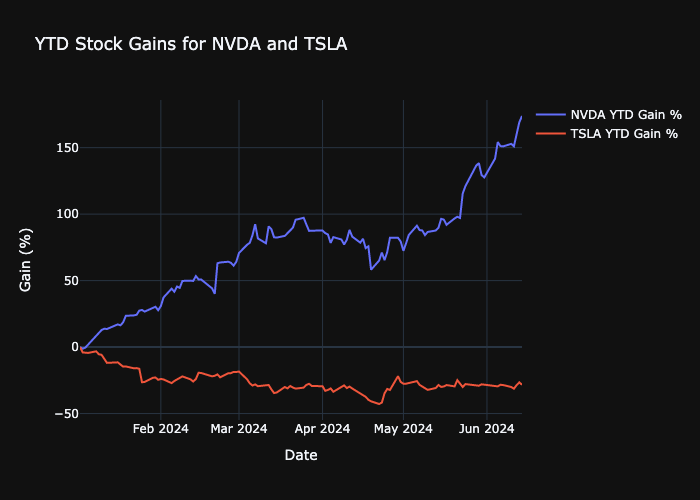

In [10]:
import os
from IPython.display import Image

Image(os.path.join("coding", "ytd_stock_gains.png"))

#### Agents with Tool Using capability

In [31]:
def get_stock_prices(stock_symbols, start_date, end_date):
    """Get the stock prices for the given stock symbols between
    the start and end dates.

    Args:
        stock_symbols (str or list): The stock symbols to get the
        prices for.
        start_date (str): The start date in the format 
        'YYYY-MM-DD'.
        end_date (str): The end date in the format 'YYYY-MM-DD'.
    
    Returns:
        pandas.DataFrame: The stock prices for the given stock
        symbols indexed by date, with one column per stock 
        symbol.
    """
    import yfinance

    stock_data = yfinance.download(
        stock_symbols, start=start_date, end=end_date
    )
    return stock_data.get("Close")

def plot_stock_prices(stock_prices, filename):
    """Plot the stock prices for the given stock symbols.

    Args:
        stock_prices (pandas.DataFrame): The stock prices for the 
        given stock symbols.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    for column in stock_prices.columns:
        plt.plot(
            stock_prices.index, stock_prices[column], label=column
                )
    plt.title("Stock Prices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.savefig(filename)

#### Define executor with the functions that it can use

In [32]:
executor = LocalCommandLineCodeExecutor(
    timeout=60,
    work_dir="coding",
    functions=[get_stock_prices, plot_stock_prices],
)

In [33]:
code_writer_agent_system_message = code_writer_agent.system_message

code_writer_agent_system_message += executor.format_functions_for_prompt()
print(code_writer_agent_system_message)

You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
    1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
    2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feed

In [35]:
import datetime

today = datetime.datetime.now().date()
message = f"Today is {today}. "\
"Create a plot showing stock gain YTD for NVDA and TLSA. "\
"Make sure the code is in markdown code block and save the figure"\
" to a file ytd_stock_gains_fn_use.png."""

In [36]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=message,
)

code_executor_agent (to code_writer_agent):

Today is 2024-06-16. Create a plot showing stock gain YTD for NVDA and TLSA. Make sure the code is in markdown code block and save the figure to a file ytd_stock_gains_fn_use.png.

--------------------------------------------------------------------------------
code_writer_agent (to code_executor_agent):

To proceed with obtaining stock prices for NVDA (Nvidia) and TSLA (Tesla) from the start of the year to today's date, 2024-06-16, and create a plot of stock gains YTD, we can use financial data APIs such as `yfinance`. However, since I can't access external APIs, I will provide the Python code you can execute to generate and save the required plot.

Steps in the code:
1. Fetch historical data for NVDA and TSLa using `yfinance`.
2. Calculate the year-to-date (YTD) gain for both stocks.
3. Plot the YTD gains on a graph.
4. Save the plot to a PNG file named "ytd_stock_gains_fn_use.png".

Here's the Python code for the given task:

```python
# 

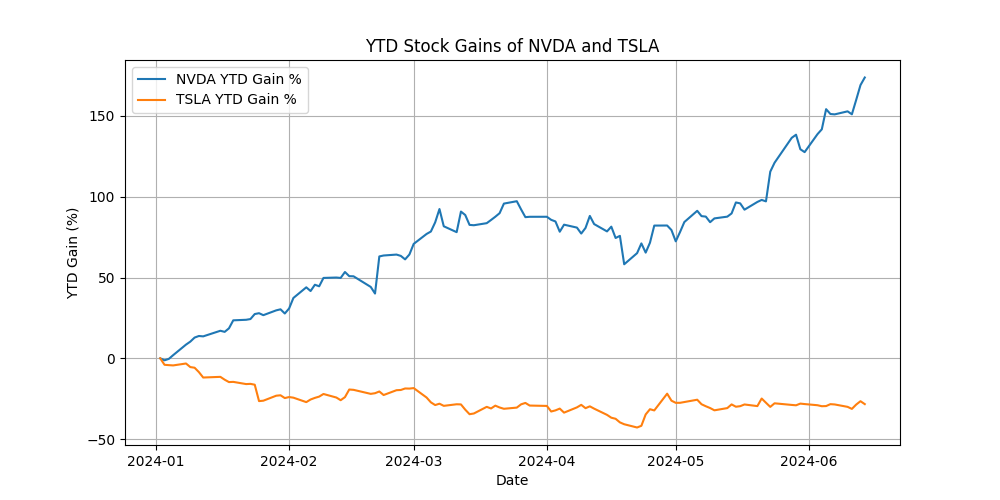

In [37]:
import os
from IPython.display import Image

Image(os.path.join("coding", "ytd_stock_gains_fn_use.png"))